In [31]:
from skimage.segmentation import clear_border
import commonfunctions as cf
import math
import os
import numpy as np
import imutils
import cv2
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_erosion, binary_dilation
from skimage.feature import canny
from skimage.filters import threshold_otsu, sobel
from skimage.transform import rotate
from skimage.transform import (hough_line, hough_line_peaks)
from scipy.stats import mode
from joblib import load
import skimage.io as io
from glob import glob

Detecting color of the plate


In [32]:

def detect_color(image):
    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define hue ranges for different colors
    hue_ranges = {
        'green': (40, 80),
        'dark_blue': (100, 140),
        'yellow': (25, 35),
        'light_blue': (85, 120),
    }

    # Create masks for each color
    color_masks = {}
    for color, (lower_hue, upper_hue) in hue_ranges.items():
        color_masks[color] = cv2.inRange(hsv_image[:, :, 0], lower_hue, upper_hue)

    # Determine the predominant color
    predominant_color = max(color_masks, key=lambda k: cv2.countNonZero(color_masks[k]))

    return predominant_color

# Looping over the images
image_files = glob(os.path.join('colors/', '*'))
for image_file in image_files:
    img = cv2.imread(image_file)
    detected_color = detect_color(img)
    print(f"Image: {image_file}, Predominant Color: {detected_color}")


Image: colors\blue.png, Predominant Color: dark_blue
Image: colors\green.png, Predominant Color: green
Image: colors\lightblue.png, Predominant Color: light_blue
Image: colors\yellow.png, Predominant Color: yellow


plate segmentation

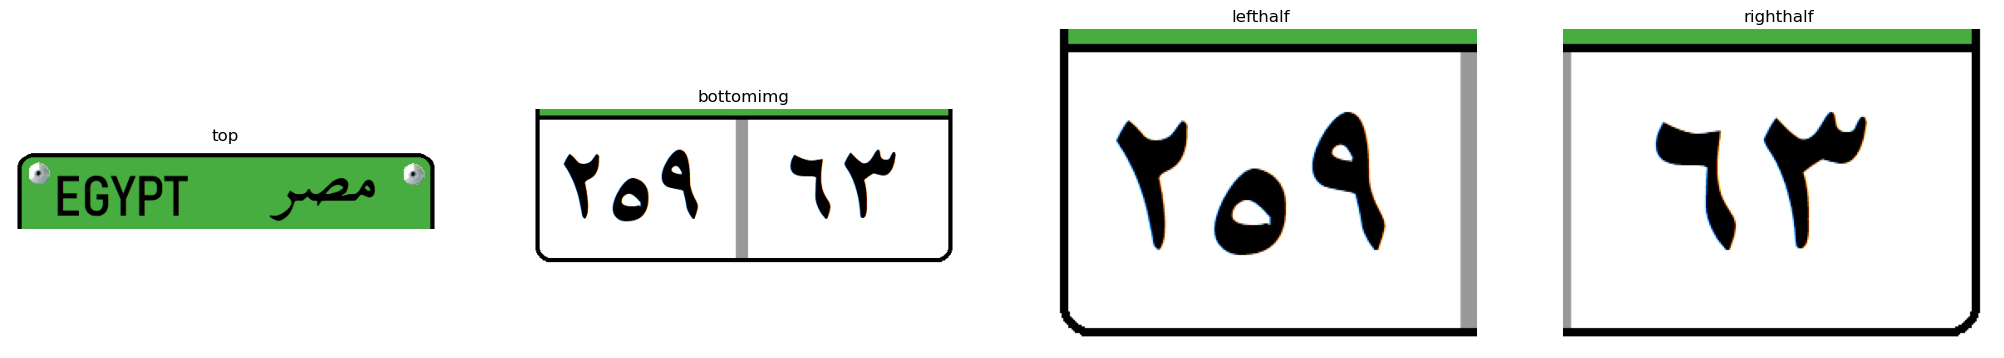

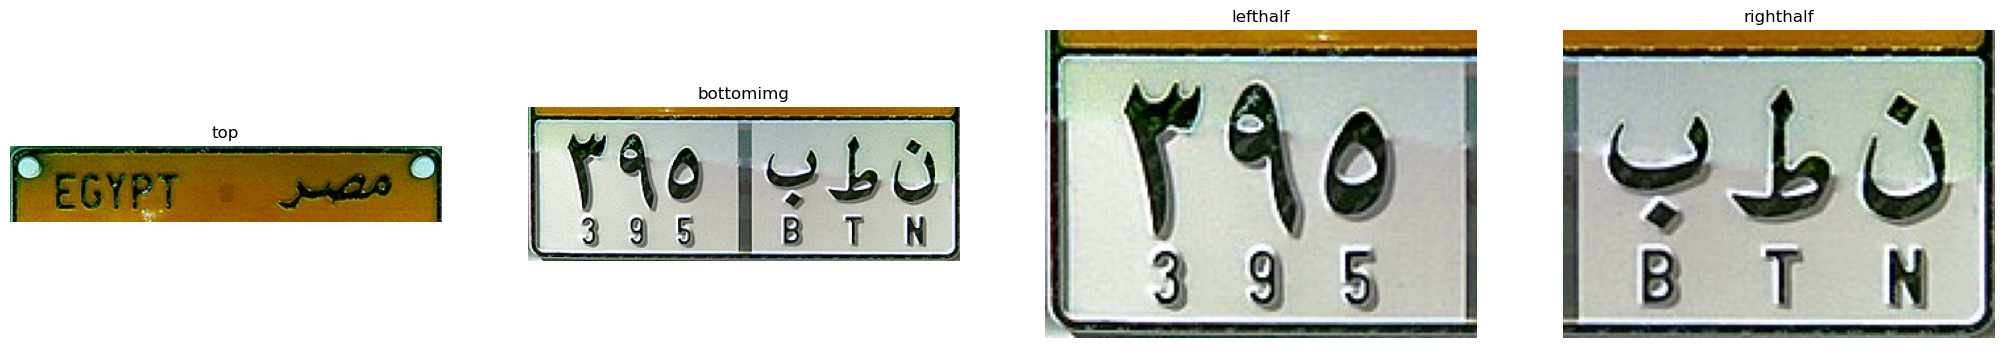

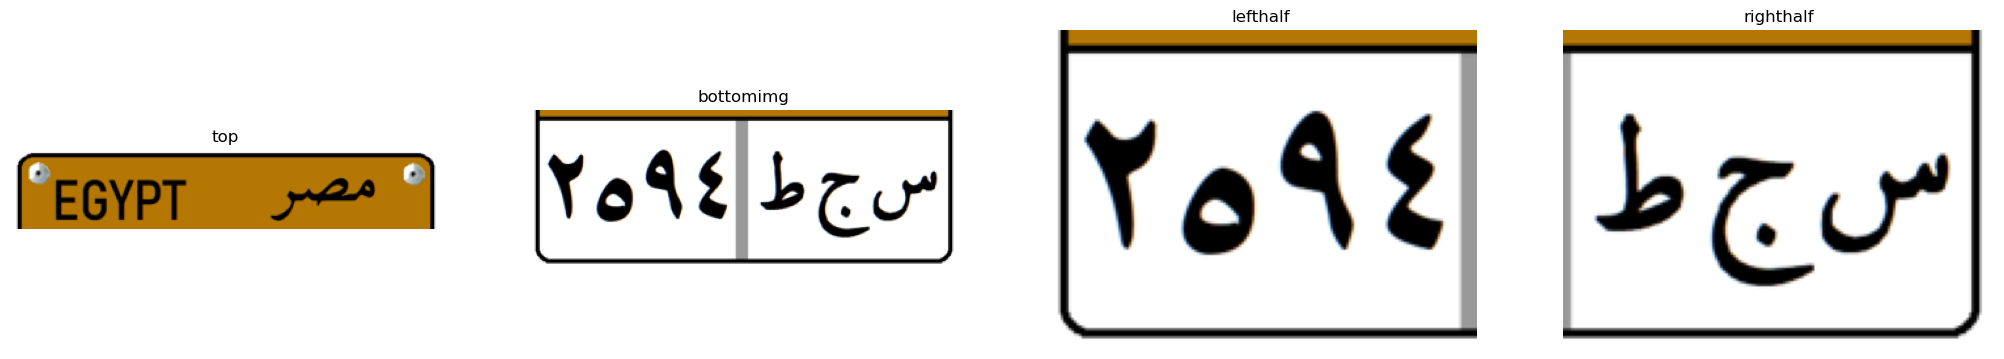

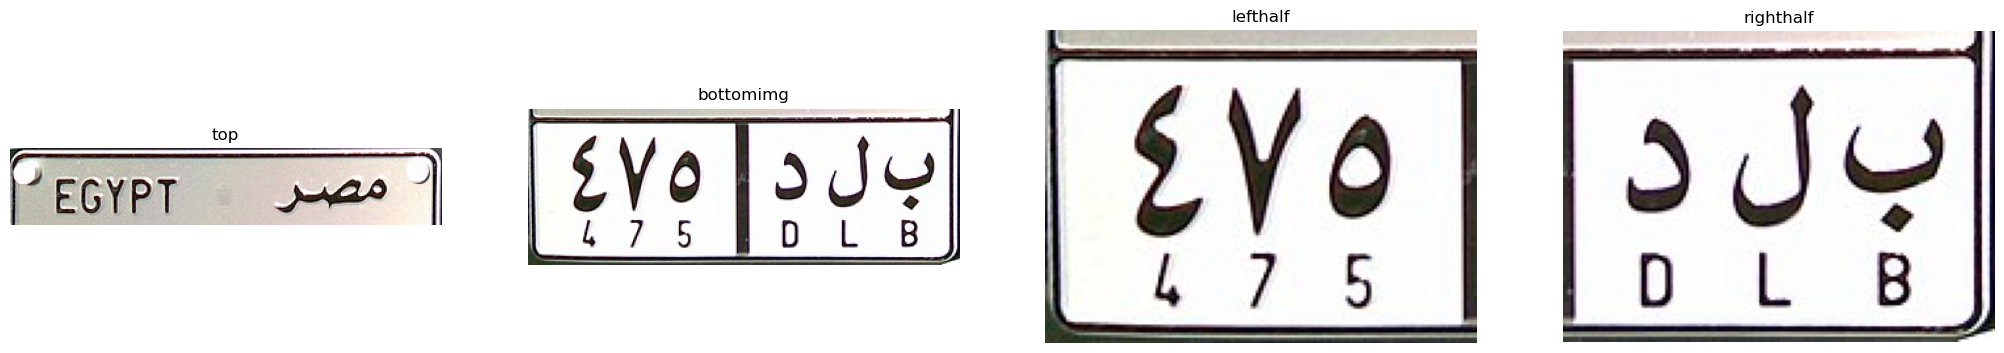

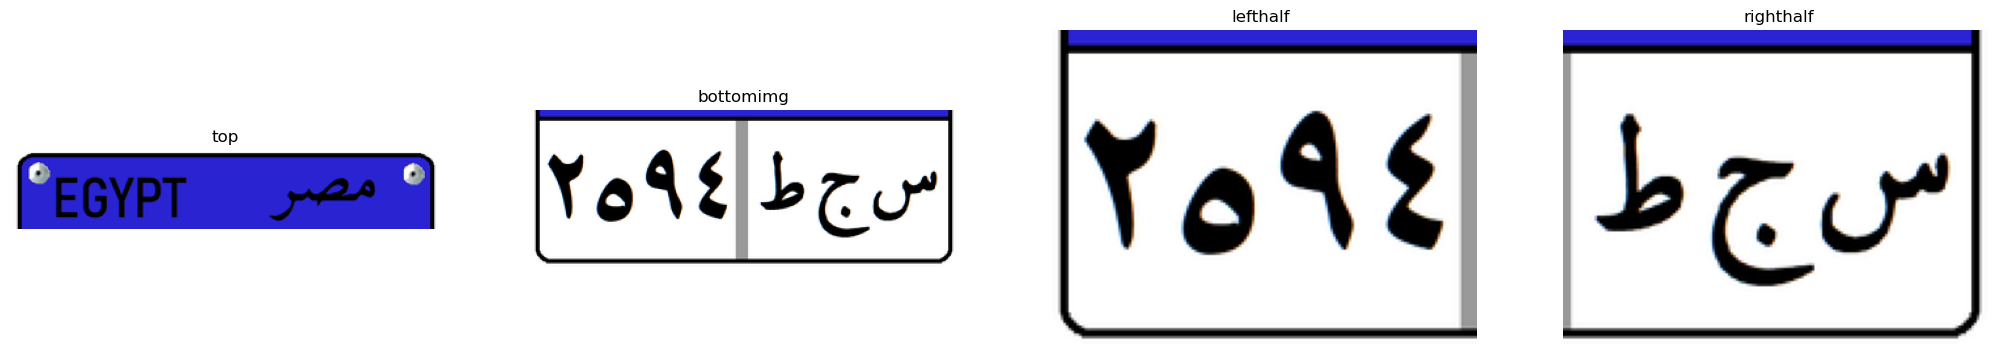

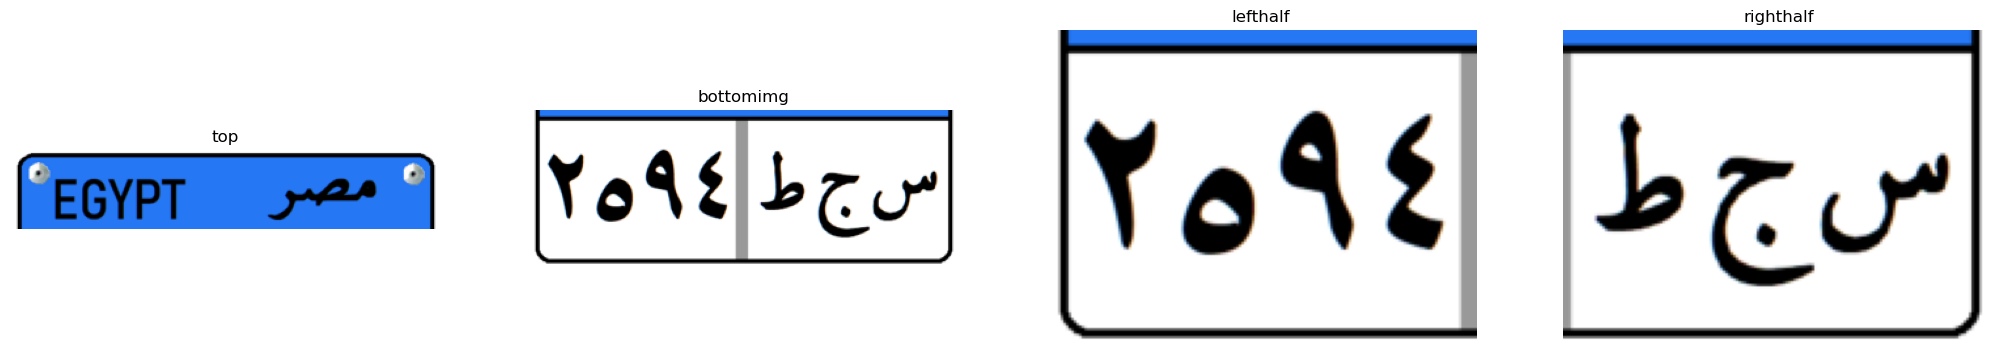

In [34]:
#this function is used to segment the plate into 3parts
#the top part contains the plate color
#the right part contains the plate letters
#the left part contains the plate number

def segment_characters(image) :
    # image is preprocessed using the preprocess_image function
    #input img is a license plate image
    #now we will try to segment the characters of the plate
    #first we will crop the high quarter of image
    
    height, width, _ = image.shape
    bottom_two_thirds_image = image[height // 3:, :]
    top_one_third_image = image[:height // 3, :]
    left_half_image = bottom_two_thirds_image[:, :width // 2]
    right_half_image = bottom_two_thirds_image[:, width // 2:]
   
    return top_one_third_image,bottom_two_thirds_image, left_half_image, right_half_image

image_files = glob(os.path.join('plate/', '*'))
for image_file in image_files:
    img = cv2.imread(image_file)
    top,bottomimg,lefthalf,righthalf=segment_characters(img)
    cf.show_images([top,bottomimg,lefthalf,righthalf],["top","bottomimg","lefthalf","righthalf"])





Now we will try to segment the numbers

In [49]:


def segment_numbers(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and aspect ratio
    min_area = 100  # Minimum contour area
    max_area = 5000  # Maximum contour area
    min_aspect_ratio = 0.2  # Minimum aspect ratio
    max_aspect_ratio = 1.5  # Maximum aspect ratio

    segmented_numbers = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        aspect_ratio = w / float(h)

        if min_area < area < max_area and min_aspect_ratio < aspect_ratio < max_aspect_ratio:
            segmented_numbers.append(image[y:y+h, x:x+w])

    return segmented_numbers

# Looping over the images
image_files = glob(os.path.join('plate/', 'plate_5.png'))
for image_file in image_files:
    img = cv2.imread(image_file)
    leftpart=segment_characters(img)[3]
    segmented_numbers = segment_numbers(leftpart)
    for i, number in enumerate(segmented_numbers):
        cv2.imwrite(f"segmented_number_{i}.png", number)
